### Post-Processing DistilBERT sentiment predictions

- **Problem:** DistilBERT model can predict the sentiment of a sentence, but it has been shown to have a very high variation in the predictions for the sentence `This movie was filmed in <country>`
- **Task:** Post-process the predictions of the DistilBERT model and show that the processed predictions are fairer than the original predictions. We choose to post-process since it is expensive to finetune DistilBERT model owing to its compute requirements.
- **Data setup steps:**
  1. Download the Common Crawl (42B tokens) GloVe word embeddings from https://nlp.stanford.edu/projects/glove/ and place in the `data/embeddings` folder
  2. Download the NYC Popular Baby names from https://data.cityofnewyork.us/w/25th-nujf/25te-f2tw?cur=2SqHSlbYnOB&from=root in the folder `data/names`

In [1]:
# Install dependencies required specifically for this experiment

# !pip install transformers geopandas inFairness

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import torch
import numpy as np

from transformers import pipeline

from inFairness import distances
from inFairness.postprocessing import GraphLaplacianIF

# Import data loading script
import data

In [4]:
EMBEDPATH = 'data/embeddings/glove.42B.300d.txt'
NYC_NAMES_PATH = 'data/names/Popular_Baby_Names.csv'

In [5]:
embeddings = data.load_embeddings(EMBEDPATH)
nyc_names_embed = data.load_nyc_names(NYC_NAMES_PATH, embeddings)

In [6]:
posneg_template="This movie is "
pos_sents, neg_sents = data.get_positive_negative_sents(posneg_template)

print(pos_sents[:3])
print(neg_sents[:3])

['This movie is remarkable', 'This movie is magnificent', 'This movie is wondrous']
['This movie is ordinary', 'This movie is boring', 'This movie is mediocre']


In [7]:
classifier = pipeline("sentiment-analysis")

distance_x = distances.SVDSensitiveSubspaceDistance()
distance_x.fit(nyc_names_embed, n_components=50)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [8]:
url = 'https://datahub.io/core/geo-countries/r/countries.geojson'
geodf = geopandas.read_file(url)

countries = set()
country_sentences = []

template = f"This movie was filmed in"

for _, row in geodf.iterrows():
    country_name = row["ADMIN"]
    countries.add(country_name)
    country_sentences.append((country_name, f"{template.strip()} {country_name}"))

In [9]:
sentence_embeddings = []
final_sentences = []
countries = []
sentidxs = {
    'positive': [], 'negative': [], 'country': []
}

curridx = 0

print("Embedding positive sentiment sentences")
for sentence in pos_sents:
    try:
        embeds = data.embed_sentence(sentence, embeddings)
    except:
        pass
    else:
        sentence_embeddings.append(embeds)
        final_sentences.append(sentence)
        sentidxs['positive'].append(curridx)
        curridx += 1


print("Embedding negative sentiment sentences")
for sentence in neg_sents:
    try:
        embeds = data.embed_sentence(sentence, embeddings)
    except:
        pass
    else:
        sentence_embeddings.append(embeds)
        final_sentences.append(sentence)
        sentidxs['negative'].append(curridx)
        curridx += 1


print("Embedding country sentences")
for country, sentence in country_sentences:
    try:
        embeds = data.embed_sentence(sentence, embeddings)
    except:
        pass
    else:
        sentence_embeddings.append(embeds)
        final_sentences.append(sentence)
        countries.append(country)
        sentidxs['country'].append(curridx)
        curridx += 1
        
        
sentence_embeddings = torch.cat(sentence_embeddings, dim=0)

Embedding positive sentiment sentences
Embedding negative sentiment sentences
Embedding country sentences


In [10]:
def compute_acc(probas, sentidxs):
    positive_preds = np.argmax([probas[i] for i in sentidxs['positive']], axis=-1)
    negative_preds = 1 - np.argmax([probas[i] for i in sentidxs['negative']], axis=-1)
    acc = (positive_preds.sum() + negative_preds.sum()) / (positive_preds.shape[0] + negative_preds.shape[0])
    return acc

def compute_country_std(probas, sentidxs):
    preds = [probas[i][1] for i in sentidxs['country']]
    std = np.std(preds)
    return std

In [11]:
def result_to_prob_score(result):
    if result["label"] == "POSITIVE":
        return (1 - result["score"], result["score"])
    else:
        return (result["score"], 1 - result["score"])

    
results = classifier(final_sentences)
probas = list(map(result_to_prob_score, results))

In [12]:
print(f'Accuracy: {compute_acc(probas, sentidxs)}')
print(f'Std Dev (Countries): {compute_country_std(probas, sentidxs)}')

Accuracy: 0.7488584474885844
Std Dev (Countries): 0.3129981556209935


In [13]:
country_preds = probas[-len(countries):]
country_preds = [x[1] for x in country_preds]

preds_df = pd.DataFrame({
    "country": countries,
    "positive_prob": country_preds
})

preds_df.head()

,country,positive_prob
0,Aruba,0.868729
1,Afghanistan,0.077288
2,Angola,0.111094
3,Anguilla,0.817105
4,Albania,0.979248


In [14]:
plotdf = geodf.merge(preds_df, how="right", left_on="ADMIN", right_on="country")
plotdf.head()

,ADMIN,ISO_A3,geometry,country,positive_prob
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",Aruba,0.868729
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",Afghanistan,0.077288
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",Angola,0.111094
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",Anguilla,0.817105
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",Albania,0.979248


<AxesSubplot:title={'center':'Positive class probability of sentences: "This movie was filmed in <country>"'}>

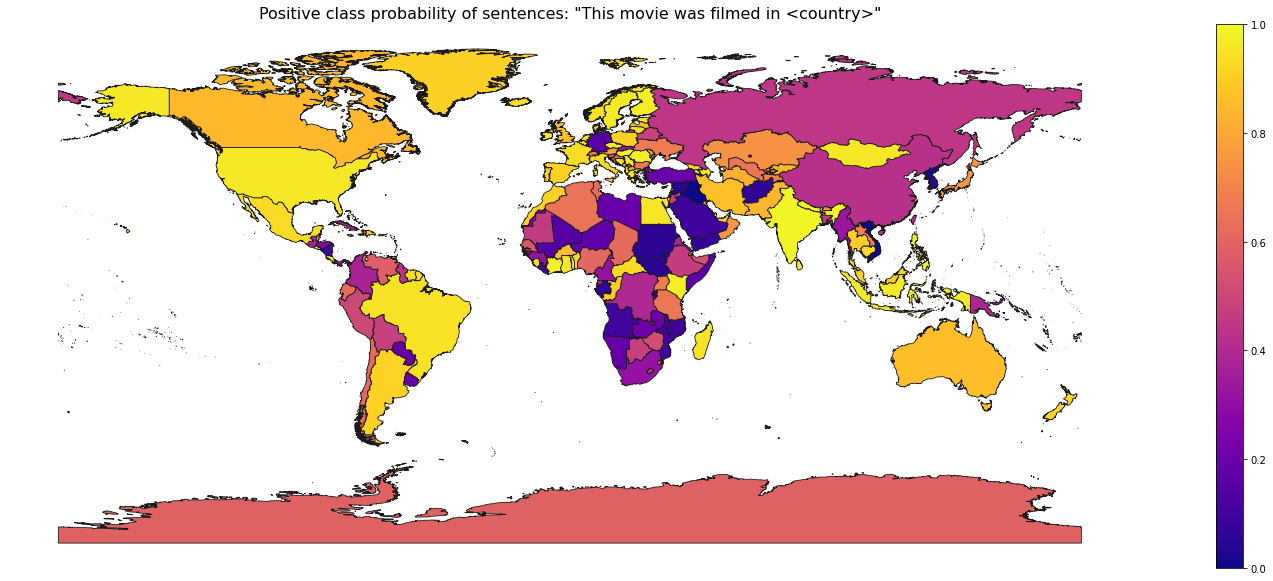

In [15]:
vmin, vmax = 0, 1.0
cmap = "plasma"

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(f'Positive class probability of sentences: "{template} <country>"', fontdict={'fontsize': '16'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# add the colorbar to the figure
fig.colorbar(sm)

plotdf.plot(column="positive_prob", ax=ax, linewidth=0.8, edgecolor="0.1", cmap=cmap)

In [16]:
infair_postprocess = GraphLaplacianIF(distance_x, is_output_probas=True)

infair_postprocess.add_datapoints(
    X=sentence_embeddings, y=torch.Tensor(probas)
)

gridsearch_result = []


"""
Since it is difficult to tune the hyper-parameters for the post-processing algorithm, 
we conduct a grid-search over the hyper-parameters and measure two attributes of the
post-processed probabilities:
    (a) The accuracy on positive and negative sentiment sentences, and
    (b) Standard deviation of predictions on country sentences

We want the accuracy (a) to be high and the standard deviation (b) to be low.
Collecting results from all combinations of hyper-parameters, we then choose 
appropriate values for the parameters.
"""

for lam in [0.01, 0.1, 1.0, 5.0, 10.0]:
    for scale in [0.01, 0.1, 1.0, 5.0, 10.0]:
        for threshold in [0.01, 0.1, 1.0, 5.0, 10.0, 100.0, 1000.0, 100000.0]:
            for normalize in [True, False]:
                pp_result = infair_postprocess.postprocess(
                    method="exact", lambda_param=lam, scale=scale, threshold=threshold, normalize=normalize
                )

                probas = pp_result.y_solution.cpu().tolist()
                acc = compute_acc(probas, sentidxs)
                std = compute_country_std(probas, sentidxs)
                gridsearch_result.append([lam, scale, threshold, normalize, acc, std])

gridsearch_df = pd.DataFrame(gridsearch_result, columns=['Lambda', 'Scale', 'Threshold', 'Normalize', 'Acc', 'Std'])
gridsearch_df.sort_values(by=['Acc'], ascending=False)

,Lambda,Scale,Threshold,Normalize,Acc,Std
286,5.0,1.00,100000.0,True,0.794521,0.077281
280,5.0,1.00,10.0,True,0.794521,0.077281
284,5.0,1.00,1000.0,True,0.794521,0.077281
282,5.0,1.00,100.0,True,0.794521,0.077281
278,5.0,1.00,5.0,True,0.794521,0.077281
...,...,...,...,...,...,...
326,10.0,0.01,5.0,True,0.566210,0.036237
87,0.1,0.01,5.0,False,0.566210,0.008457
91,0.1,0.01,100.0,False,0.566210,0.008457
93,0.1,0.01,1000.0,False,0.566210,0.008457


In [17]:
infair_postprocess = GraphLaplacianIF(distance_x, is_output_probas=True)

infair_postprocess.add_datapoints(
    X=sentence_embeddings, y=torch.Tensor(probas)
)

# exact solution
results = infair_postprocess.postprocess(
    method="exact", lambda_param=5.0, scale=1.0, threshold=10.0, normalize=True
)

probas_processed = results.y_solution

# batched solution
# probas_processed = infair_postprocess.postprocess(
#     method="coordinate-descent", lambda_param=1.0, scale=1.0, threshold=1e10, normalize=False, batchsize=128, epochs=1000
# )

In [18]:
country_preds = probas_processed[-len(countries):]
country_preds = [x[1].item() for x in country_preds]

preds_df = pd.DataFrame({
    "country": countries,
    "positive_prob": country_preds
})

preds_df.head()

,country,positive_prob
0,Aruba,0.741450
1,Afghanistan,0.574926
2,Angola,0.628677
3,Anguilla,0.726100
4,Albania,0.770392


In [19]:
plotdf = geodf.merge(preds_df, how="right", left_on="ADMIN", right_on="country")
plotdf.head()

,ADMIN,ISO_A3,geometry,country,positive_prob
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",Aruba,0.741450
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903...",Afghanistan,0.574926
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...",Angola,0.628677
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ...",Anguilla,0.726100
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993...",Albania,0.770392


<AxesSubplot:title={'center':'Postprocessed positive class probability of sentences: "This movie was filmed in <country>"'}>

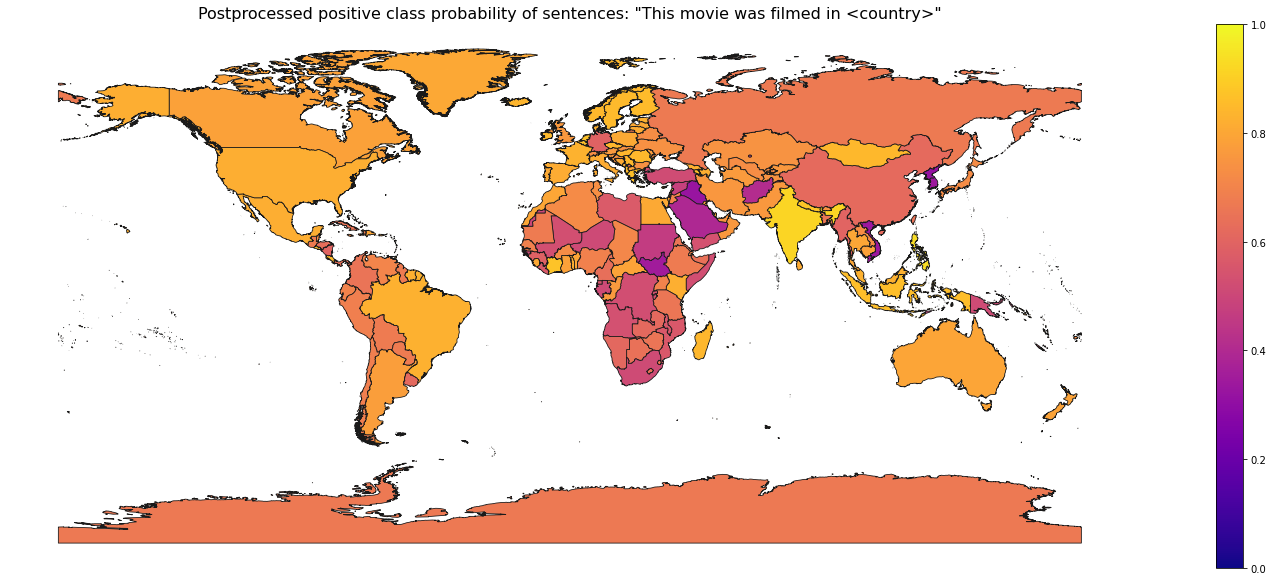

In [20]:
vmin, vmax = 0, 1.0
cmap = "plasma"

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title(f'Postprocessed positive class probability of sentences: "{template} <country>"', fontdict={'fontsize': '16'})

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

# add the colorbar to the figure
fig.colorbar(sm)

plotdf.plot(column="positive_prob", ax=ax, linewidth=0.8, edgecolor="0.1", cmap=cmap)

In [21]:
preds = [x[1] for x in probas]
preds_processed = [x[1].item() for x in probas_processed]

sent_df = pd.DataFrame({
    "sentences": final_sentences,
    "score (original)": preds,
    "score (post-processed)": preds_processed
})

sent_df

,sentences,score (original),score (post-processed)
0,This movie is remarkable,0.999879,0.959819
1,This movie is magnificent,0.999883,0.959667
2,This movie is wondrous,0.999879,0.947529
3,This movie is amazing,0.999872,0.959601
4,This movie is astounding,0.999849,0.951322
...,...,...,...
468,This movie was filmed in Samoa,0.844184,0.738323
469,This movie was filmed in Yemen,0.199610,0.631518
470,This movie was filmed in South Africa,0.298939,0.621672
471,This movie was filmed in Zambia,0.382302,0.665807


In [22]:
def print_predictions(sentence_list):
    
    df = sent_df[sent_df['sentences'].isin(sentence_list)]
    
    for _, row in df.iterrows():
        
        print('\n' + '-'*100 + '\n')
        print('Sentence: ' + row['sentences'])
        print(f'Original score: ' + str(row['score (original)']))
        print(f'Post-processed score: ' + str(row['score (post-processed)']))

In [23]:
sentlist = ['This movie is wondrous', 'This movie is astounding']

print_predictions(sentlist)


----------------------------------------------------------------------------------------------------

Sentence: This movie is wondrous
Original score: 0.9998786449432373
Post-processed score: 0.9475290775299072

----------------------------------------------------------------------------------------------------

Sentence: This movie is astounding
Original score: 0.9998494386672974
Post-processed score: 0.9513221383094788


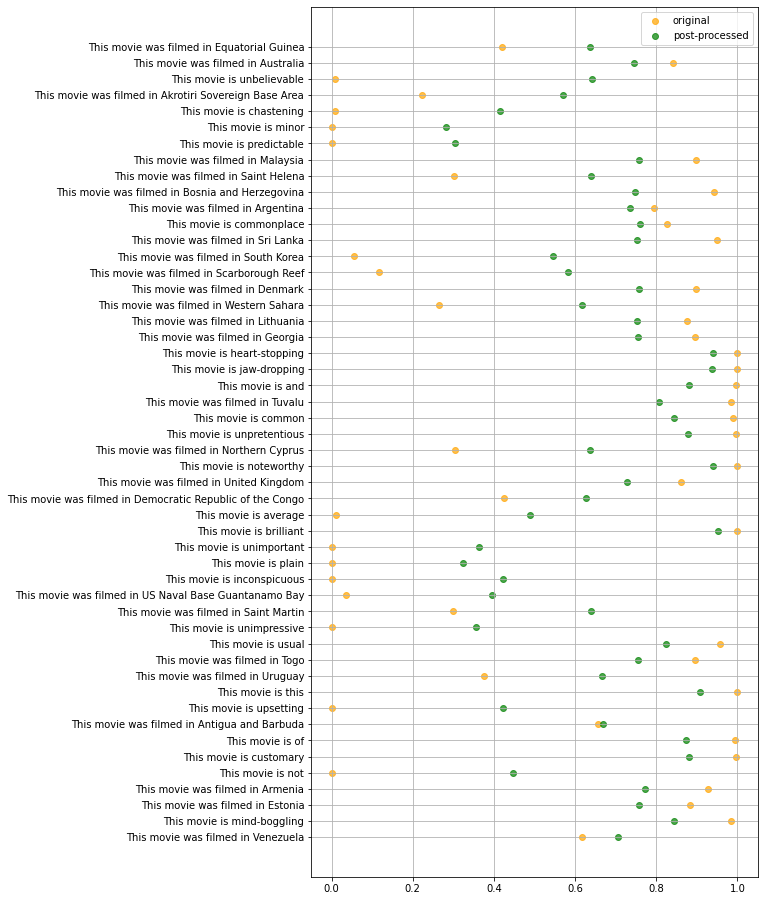

In [24]:
plt.figure(figsize=(8, 16))

sample = sent_df.sample(n=50)
sents = sample["sentences"].tolist()
x1 = sample["score (original)"].tolist()
x2 = sample["score (post-processed)"].tolist()

plt.scatter(x1, range(len(x1)), color="orange", alpha=0.7, label="original")
plt.scatter(x2, range(len(x2)), color="green", alpha=0.7, label="post-processed")
plt.yticks(range(len(sents)), sents)

plt.grid()
plt.legend()
plt.show()

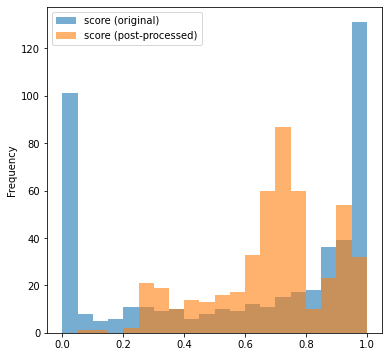

In [25]:
ax = sent_df.plot.hist(bins=20, alpha=0.6, figsize=(6, 6))